# Text Classification of IMDB using BERT Model

- First, install the required libraries using `pip install datasets transformers`. Import necessary modules: `list_datasets` and `load_dataset` from the `datasets` library, `pandas` and `matplotlib.pyplot` for data manipulation and visualization, and several components from `transformers` for model handling, including `AutoTokenizer`, `AutoModelForSequenceClassification`, `Trainer`, and `TrainingArguments`.

- Begin by listing all available datasets with `list_datasets()`. Load the IMDB dataset using `load_dataset("imdb")` and inspect the first example in the training set and the first three examples in the test set. To reduce computation time, shuffle the training dataset and select the first 2000 examples. Split this reduced training set into training and validation subsets with an 80-20 split, then update the original dataset dictionary to include the new validation set. Similarly, shuffle and reduce the test set to the first 400 examples. Convert the dataset format to pandas with `imdb.set_format('pandas')` and display a random sample of 10 reviews from the training set.

- Inspect and clean the text data by replacing empty strings. Add a new column to count the number of words per review and visualize this with a boxplot, grouped by label. After visualization, reset the dataset format with `imdb.reset_format()`.

- Proceed by loading a pre-trained tokenizer, in this case, "distilbert-base-cased", and define a tokenization function that applies this tokenizer to the dataset. Apply this function to the dataset using `map` to tokenize all text entries.

- Prepare the model by importing relevant classes and identifying available models in the `transformers` library. Load a pre-trained sequence classification model, set to use a GPU if available. Create a smaller subset of the IMDB dataset for quick testing by shuffling and selecting smaller portions of the training, validation, and test sets. Tokenize this smaller dataset using the previously defined tokenization function. Define training arguments such as the output directory, number of epochs, learning rate, batch sizes, weight decay, evaluation strategy, logging steps, and optimizer type.

- Create a `Trainer` instance with the model, training arguments, tokenized datasets, and tokenizer. Train the model and evaluate its performance on the validation set. Predict the labels on the test set and compute accuracy using `accuracy_score` from `sklearn.metrics`. Define a custom function `get_accuracy` to compute accuracy from the predictions and labels, and retrain the model using this metric.

- Finally, increase the batch size and logging steps for training on the full IMDB dataset. Create a `Trainer` with updated arguments, retrain the model, evaluate it, and save the trained model. Use the `pipeline` from `transformers` to create a text classification pipeline with the fine-tuned model, and classify sample texts to test the model's predictions.

In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [ ]:
from datasets import list_datasets, load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from sklearn.metrics import accuracy_score
import re

In [ ]:
from datasets import list_datasets
list_datasets()


<ipython-input-3-a55d55f678a9>:2: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['amirveyseh/acronym_identification',
 'ade-benchmark-corpus/ade_corpus_v2',
 'UCLNLP/adversarial_qa',
 'Yale-LILY/aeslc',
 'nwu-ctext/afrikaans_ner_corpus',
 'fancyzhx/ag_news',
 'allenai/ai2_arc',
 'google/air_dialogue',
 'komari6/ajgt_twitter_ar',
 'legacy-datasets/allegro_reviews',
 'tblard/allocine',
 'mutiyama/alt',
 'fancyzhx/amazon_polarity',
 'defunct-datasets/amazon_reviews_multi',
 'defunct-datasets/amazon_us_reviews',
 'sewon/ambig_qa',
 'nala-cub/americas_nli',
 'legacy-datasets/ami',
 'gavinxing/amttl',
 'facebook/anli',
 'sealuzh/app_reviews',
 'deepmind/aqua_rat',
 'google-research-datasets/aquamuse',
 'bigIR/ar_cov19',
 'hadyelsahar/ar_res_reviews',
 'iabufarha/ar_sarcasm',
 'abuelkhair-corpus/arabic_billion_words',
 'QCRI/arabic_pos_dialect',
 'halabi2016/arabic_speech_corpus',
 'hsseinmz/arcd',
 'ramybaly/arsentd_lev',
 'allenai/art',
 'arxiv-community/arxiv_dataset',
 'tuanphong/ascent_kb',
 'achrafothman/aslg_pc12',
 'AmazonScience/asnq',
 'facebook/asset',
 'nilc-

In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb")
imdb

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
imdb['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [ ]:
imdb['test'][:3]

{'text': ['I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as

In [ ]:
imdb['train'] = imdb['train'].shuffle(seed=1).select(range(2000))
imdb['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [ ]:
imdb_train_validation = imdb['train'].train_test_split(train_size=0.8)
imdb_train_validation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [ ]:
imdb_train_validation['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 400
})

In [ ]:
imdb_train_validation['validation'] = imdb_train_validation.pop('test')
imdb_train_validation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [ ]:
imdb.update(imdb_train_validation)
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [ ]:
imdb['test'] = imdb['test'].shuffle(seed=1).select(range(400))
imdb['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 400
})

In [ ]:
imdb['unsupervised'][:3]


{'text': ['This is just a precious little diamond. The play, the script are excellent. I cant compare this movie with anything else, maybe except the movie "Leon" wonderfully played by Jean Reno and Natalie Portman. But... What can I say about this one? This is the best movie Anne Parillaud has ever played in (See please "Frankie Starlight", she\'s speaking English there) to see what I mean. The story of young punk girl Nikita, taken into the depraved world of the secret government forces has been exceptionally over used by Americans. Never mind the "Point of no return" and especially the "La femme Nikita" TV series. They cannot compare the original believe me! Trash these videos. Buy this one, do not rent it, BUY it. BTW beware of the subtitles of the LA company which "translate" the US release. What a disgrace! If you cant understand French, get a dubbed version. But you\'ll regret later :)',
  'When I say this is my favourite film of all time, that comment is not to be taken lightly

In [ ]:
imdb.pop('unsupervised')
imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 400
    })
})

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 250)

In [ ]:
imdb.set_format('pandas')
df = imdb['train'][:]
df.sample(frac=1 ,random_state=1).head(10)

,text,label
75,"I may be biased, I am the author of the novel The Hungry Bachelors Club, self-published in 1994. The screenplay was written by my good friend and hungry bachelor, Fred Dresch, who was the inspiration for the character Marlon in the film. I couldn...",1
1284,"When robot hordes start attacking major cities, who will stop the madman behind the attacks? Sky Captain!!! Jude Law plays Joe Sullivan, the ace of the skyways, tackling insurmountable odds along with his pesky reporter ex-girlfriend Polly Perkin...",0
408,"To me this was more a wake up call, and realization that most all we see, hear, read and think about most anything, is dependent on what the media feeds us. This is a classic example of high level spin doctors attempting to control the masses thr...",1
1282,The Godfather Part I was a stunning look inside the fictional Corleone family and how an innocent young man was all but forced into circumstances he never wanted to have a part of. The Godfather Part II shows that young man's acceptance of his ne...,0
1447,"This is not a commentary on the actual movie, but on the RUSCICO DVD release for North America. I don't know if there have been different releases and updates, but the disks we rented had a 2000 copyright on them, if that means anything. Anyway, ...",0
1144,"I remember watching this is its original airing in 1962 as a five or six year old and REALLY enjoying this. I recently had the opportunity to watch it again, for the first time since then, as it was aired on ""Walt Disney Presents"" on the Disney C...",1
1381,"I´m glad that someone has made a movie about how hard it is to risk your heart for a second time. Or third. This movie is exactly what it promises to be - lovely, amusing and it gives you this good feeling around your heart when it ends. The plot...",1
181,Ms Patty Duke's story about her life and struggles with manic depression were just like my life struggles. I saw myself acting out just like her. I was so amazed at the similarities of our lives to include the sexual abuse that we both endured as...,1
1183,I reflect back to the days when I held my boyfriends hat to smell him into existence in my time alone when I was 16. The little moments of this film are so accurate and right on pace with what is going on in the minds and hearts of young girls du...,1
1103,My first clue about how bad this was going to be was when the video case said it was from the people who brought us Blair Witch Project which was a masterpiece in comparison to this piece of garbage. The acting was on the caliber of a 6th grade p...,0


In [ ]:
df.loc[0, 'text']

'I rank this the best of the Zorro chapterplays.The exciting musical score adds punch to an exciting screen play.There is an excellent supporting cast and mystery villain that will keep you guessing until the final chapter.Reed Hadley does a fine job as Don Diego and his alter ego Zorro.Last,but certainly not least,is the great directing team of Whitney and English.'

In [ ]:

df['text'] = df.text.str.replace('', '')
df.loc[0, 'text']

'I rank this the best of the Zorro chapterplays.The exciting musical score adds punch to an exciting screen play.There is an excellent supporting cast and mystery villain that will keep you guessing until the final chapter.Reed Hadley does a fine job as Don Diego and his alter ego Zorro.Last,but certainly not least,is the great directing team of Whitney and English.'

In [ ]:
df.label.value_counts()

label
0    811
1    789
Name: count, dtype: int64

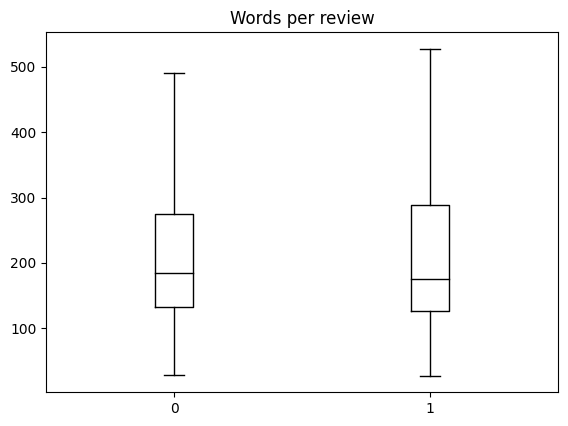

In [ ]:
df["Words per review"] = df["text"].str.split().apply(len)
df.boxplot("Words per review", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
imdb.reset_format()

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-cased"
#checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

imdb_encoded = imdb.map(tokenize_function, batched=True, batch_size=None)
imdb_encoded

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 400
    })
})

In [ ]:
print(imdb_encoded['train'][0])


{'text': 'I rank this the best of the Zorro chapterplays.The exciting musical score adds punch to an exciting screen play.There is an excellent supporting cast and mystery villain that will keep you guessing until the final chapter.Reed Hadley does a fine job as Don Diego and his alter ego Zorro.Last,but certainly not least,is the great directing team of Whitney and English.', 'label': 1, 'input_ids': [101, 146, 3997, 1142, 1103, 1436, 1104, 1103, 163, 1766, 2180, 6073, 11044, 1116, 119, 1109, 11215, 2696, 2794, 9807, 9592, 1106, 1126, 11215, 3251, 1505, 119, 1247, 1110, 1126, 6548, 4374, 2641, 1105, 8069, 14081, 1115, 1209, 1712, 1128, 18453, 1235, 1103, 1509, 6073, 119, 7527, 23953, 1674, 170, 2503, 2261, 1112, 1790, 4494, 1105, 1117, 13000, 15550, 163, 1766, 2180, 119, 4254, 117, 1133, 4664, 1136, 1655, 117, 1110, 1103, 1632, 10404, 1264, 1104, 9567, 1105, 1483, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
import transformers
import re

[x for x in dir(transformers) if re.search(r'^AutoModel', x)]

['AutoModel',
 'AutoModelForAudioClassification',
 'AutoModelForAudioFrameClassification',
 'AutoModelForAudioXVector',
 'AutoModelForCTC',
 'AutoModelForCausalLM',
 'AutoModelForDepthEstimation',
 'AutoModelForDocumentQuestionAnswering',
 'AutoModelForImageClassification',
 'AutoModelForImageSegmentation',
 'AutoModelForImageToImage',
 'AutoModelForInstanceSegmentation',
 'AutoModelForKeypointDetection',
 'AutoModelForMaskGeneration',
 'AutoModelForMaskedImageModeling',
 'AutoModelForMaskedLM',
 'AutoModelForMultipleChoice',
 'AutoModelForNextSentencePrediction',
 'AutoModelForObjectDetection',
 'AutoModelForPreTraining',
 'AutoModelForQuestionAnswering',
 'AutoModelForSemanticSegmentation',
 'AutoModelForSeq2SeqLM',
 'AutoModelForSequenceClassification',
 'AutoModelForSpeechSeq2Seq',
 'AutoModelForTableQuestionAnswering',
 'AutoModelForTextEncoding',
 'AutoModelForTextToSpectrogram',
 'AutoModelForTextToWaveform',
 'AutoModelForTokenClassification',
 'AutoModelForUniversalSegmentatio

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(checkpoint, num_labels=num_labels)
         .to(device))

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import DatasetDict

tiny_imdb = DatasetDict()
tiny_imdb['train'] = imdb['train'].shuffle(seed=1).select(range(50))
tiny_imdb['validation'] = imdb['validation'].shuffle(seed=1).select(range(10))
tiny_imdb['test'] = imdb['test'].shuffle(seed=1).select(range(10))

tiny_imdb_encoded = tiny_imdb.map(tokenize_function, batched=True, batch_size=None)
tiny_imdb_encoded

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 50
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10
    })
})

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(tiny_imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-tiny-imdb"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )
training_args

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
f

In [ ]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();


Epoch,Training Loss,Validation Loss
1,0.710000,0.697621
2,0.686700,0.697582


In [ ]:
preds = trainer.predict(tiny_imdb_encoded['test'])
preds

PredictionOutput(predictions=array([[ 0.0324349 ,  0.02037241],
       [-0.02957679,  0.01465542],
       [ 0.04409367,  0.0011611 ],
       [ 0.01873136,  0.04680309],
       [ 0.03574382,  0.0262014 ],
       [ 0.00169124,  0.01764791],
       [ 0.02436504,  0.01540717],
       [ 0.00035846,  0.00702851],
       [-0.01887175,  0.02194332],
       [-0.02196237,  0.01903927]], dtype=float32), label_ids=array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0]), metrics={'test_loss': 0.6958212852478027, 'test_runtime': 10.4473, 'test_samples_per_second': 0.957, 'test_steps_per_second': 0.191})

In [ ]:
preds.predictions.argmax(axis=-1)


array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1])

In [ ]:
preds.label_ids


array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))

0.5

In [ ]:
def get_accuracy(preds):
  predictions = preds.predictions.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds.predictions.argmax(axis=-1))
  return {'accuracy': accuracy}

In [ ]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  compute_metrics=get_accuracy,
                  args=training_args,
                  train_dataset=tiny_imdb_encoded["train"],
                  eval_dataset=tiny_imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.669300,0.705072,0.500000
2,0.661800,0.707201,0.500000


In [ ]:
batch_size = 16
logging_steps = len(imdb_encoded["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-imdb"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Trainer

torch.cuda.empty_cache()

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=imdb_encoded["train"],
                  eval_dataset=imdb_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss


In [ ]:
trainer.evaluate()


In [ ]:
trainer.save_model()


In [ ]:
model_name


In [ ]:
from transformers import pipeline
classifier = pipeline('text-classification', model=model_name)
classifier('This is not my idea of fun')

In [ ]:
classifier('This was beyond incredible')
